# Numerical exercise 02


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']



## Exercise 02.1

#### Assignment
- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

Show a picture of both your estimations of $I$ and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$.

#### Resolution
Resolving ingegrals with Monte Carlo methods means using the mean method to estimate the integral. Given a generic integral $I = \int_a^b f(x) dx$, it can be estimated as:
$$I = \int_a^b f(x) dx = (b-a) \langle f \rangle = (b-a) \frac{1}{N} \sum_{i=1}^N f(x_i) $$
where $x_i$ are random numbers extracted from a uniform distribution in $[a,b]$.
More generally, the integral can be defined as:
$$I = \int_a^b g(x) p(x) dx $$
where $p(x)$ is a probability distribution.

For the second point of the exercise, we must use the importance sampling method. This consists in choosing a distribution $d(x)$ that samples values closer to the function $f(x)$. Given the original distribution $p(x)$, we can call $f(x) = g(x) p(x)$ the integral can be estimated as:
$$
I = \int \left[ \frac{g(x) p(x)}{d(x)} \right] d(x) dx
$$
where $d(x)$ is the new distribution. The original distribution $p(x)$ can be defined as $p(x) = 1$.
The integral can be estimated as:
$$
I = \frac{1}{N} \sum_{i=1}^N \frac{f(x_i)}{d(x_i)}
$$
where $x_i$ are random numbers extracted from the distribution $d(x)$.

I have chosen the distribution $d(x) = 2-2x$, which is a linear function already normalized in the given interval of $[0,1]$.

#### Code
Again, this code uses classes derived from the ```BlockingAvg``` class. Depending of the distribution used to sample the values $x_i$, we'll be introducing new methods to the base class that will be used by the overriden ```Funny``` method.
The function $f(x)$ is defined in the new class ```Function```. This class has a method ```Eval(double x)``` that returns the value of the function in a given point $x$. This object is passed to the ```BlockingMonte``` class at construction time.
For the uniform distribution we have the ```BlockingMonte``` class. This class has a few new members:
- ```Function``` object, described before
- ```double a, b``` the limits of the integral
- ```Denominator``` and ```Probability``` methods that return the denominator and the probability of the distribution used to sample the values $x_i$

The ```Funny``` method is overriden to use the new distribution. The method is defined as:
```cpp
void BlockingMonte::Funny(Random &rnd){
    double x{Probability(rnd)};
    sum += (b-a)*(fun->Eval(x))/Denominator(x);
}
```
The method ```Probability``` returns a value sampled from the distribution $d(x)$. In the class ```BlockingMonte``` this is just a value sampled from the uniform distribution, and the ```Denominator(double x)``` returns $1$.

The derived class ```BlockingLin``` overrides the ```Denominator``` and ```Probability``` methods. The value is sampled thanks to the inverse method. The method ```Probability``` is defined as:
```cpp
double MonteLin::Probability(Random &rnd){
    double x{rnd.Rannyu(a, b)};
    return 1.-sqrt(1.-x);
}
```
while the ```Denominator(double x)``` is defined as:
```cpp
double MonteLin::Denominator(double x){
    return 2.-2.*x;
}
```


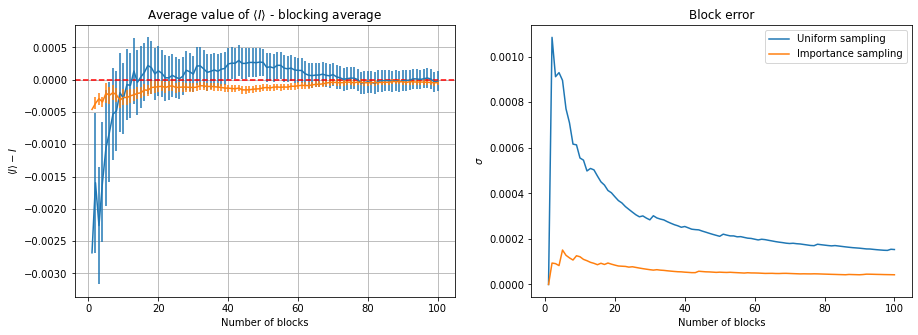

In [6]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex02.1a.dat", unpack=True, usecols=(0,1,2))
vn_throws, vcum_avg, vblock_error = np.loadtxt("../data/ex02.1b.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-1, yerr=block_error, label="Uniform sampling")
plt.errorbar(vn_throws, vcum_avg-1, yerr=vblock_error, label="Importance sampling")
plt.axhline(y=0, color='r', linestyle='--')
plt.title(r"Average value of $\langle I \rangle$ - blocking average")
plt.xlabel('Number of blocks')
plt.ylabel(r"$\langle I \rangle - I$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error, label="Uniform sampling")
plt.plot(vn_throws, vblock_error, label="Importance sampling")
plt.title("Block error")
plt.xlabel('Number of blocks')
plt.ylabel(r"$\sigma$")

plt.legend()
plt.show()

### Some observations
We can se from the plots that the importance sampling integration presents closer results to the analytical solution from the first few blocks, but converges to the same values in about the same time.

## Exercise 02.2

#### Assignment
- 3D Random Walks (RW) on a cubic lattice and in the continuum: Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Suggestion: divide your $M$ throws into a reasonable number of blocks, compute $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ as function of the step $i\in [0,10^2]$ in each block and use these values (for fixed $i$) to obtain the average value and its statistical uncertainty.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

#### Resolution
The random walk consist in a walker that takes steps in a random direction. In our case, the walker lives in a 3D space. We expect the distance to follow a diffusive behavior, behaving as $\propto \sqrt{N}$.

The distance $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ is calculated as the mean of the distance from the origin at each step. The number of steps used is $100$, while for the blocking method we used $100$ blocks over a total of $10^4$ throws.
In the analysis, we will fit the data with a function $f(N) = k \sqrt{N}$ to verify the diffusive behavior.

#### Code
The code is structured in a similar way as the previous exercise. The base class is ```BlockingAvg```, and the derived classes are ```BlockingLattice``` and ```ContinueLattice```. The first class simulates the random walk in a cubic lattice, while the second class (derived from the first) simulates the random walk in the continuum.
```BlockingLattice``` has new members to store current averages for each step, and ```x, y, z``` coordinates to propagate from. The method ```Funny```  is overridden to take a random step. For the discrete cae:
```cpp
void BlockingLattice::Funny(Random &rnd){
    //decide which direction will be the step
    int which_dir{(rnd.Rannyu(0,3))};
    //decide if you want to step forward or backward
    int which_way{rnd.Rannyu(-1.,1.)<0?-1:1};
    double step[3] = {x, y, z};
    step[which_dir] += which_way;
    x = step[0];
    y = step[1];
    z = step[2];
}
```  
while for the continuous case, where the distribution og the $\phi$ angle is $1/2 \sin(x)$, and sampled thanks to the inverse CDF method.
```cpp
void ContinueLattice::Funny(Random &rnd){
    //theta is uniform
    double theta{rnd.Rannyu(0,2.*(double)M_PI)};
    //phi should be distributed as 1/2 sin(x)
    double r{rnd.Rannyu()};
    //inverse cdf of 1/2 sin(x)
    double phi{acos(1.-2.*r)};
    x += sin(phi)*cos(theta);
    y += sin(phi)*sin(theta);
    z += cos(phi);
}
```



Fit parameter k: 1.002


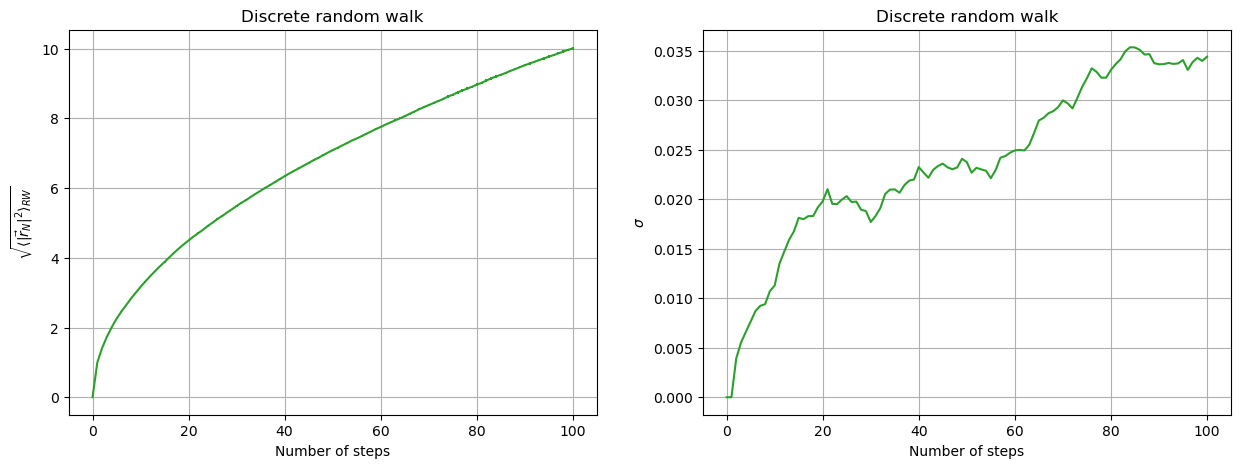

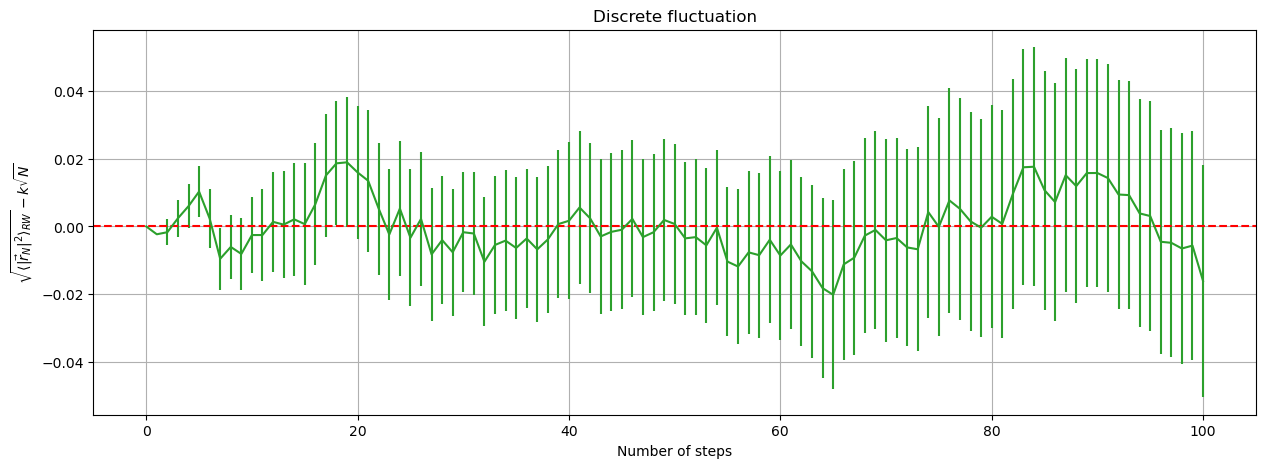

In [4]:
def k_law(x, k):
    return k * np.sqrt(x)

step, cum_avg, cumerror = np.loadtxt("../data/ex_02.2a.dat", unpack=True, usecols=(0,1, 2))

popt, pcov = curve_fit(k_law, step, cum_avg)

print("Fit parameter k: {ka:.3f}".format(ka=popt[0]))

x = np.linspace(0, 100, 1000)
y = k_law(x, popt[0])

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(step, cum_avg, yerr=cumerror, color=colors[2])
# plt.plot(x, y, label="Fit", color='red')
plt.title("Discrete random walk")
plt.xlabel("Number of steps")
plt.ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(step, cumerror, color=colors[2])
plt.title("Discrete random walk")
plt.xlabel("Number of steps")
plt.ylabel(r"$\sigma$")
plt.grid(True)

plt.show()

plt.figure(figsize=(15,5))
plt.errorbar(step, cum_avg-k_law(step, popt[0]), yerr=cumerror, color=colors[2])
plt.axhline(0, color='red', linestyle='--')
plt.title("Discrete fluctuation")
plt.xlabel("Number of steps")
plt.ylabel(r"$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}} - k \sqrt{N}$")
plt.grid(True)

plt.show()


Fit parameter k: 1.000


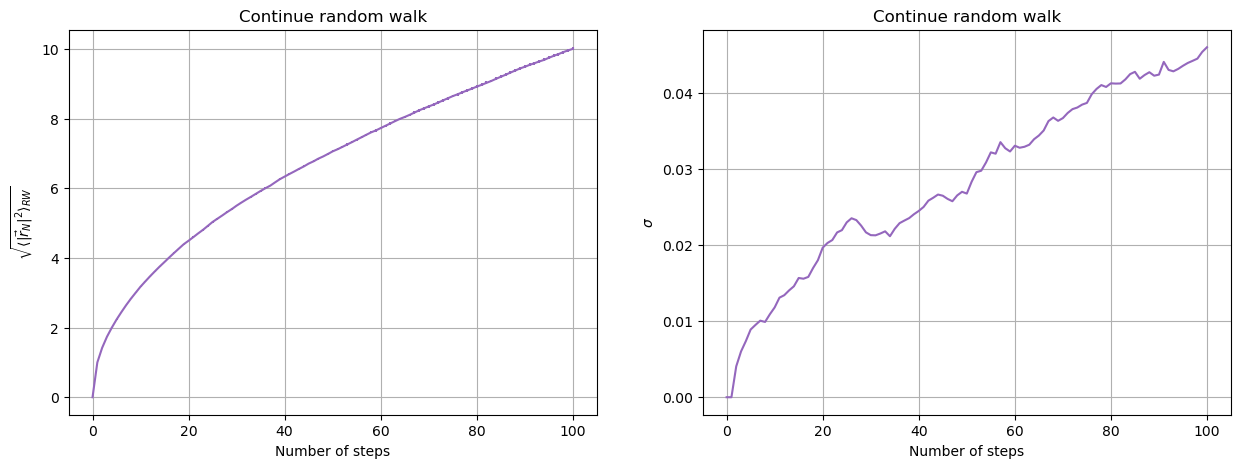

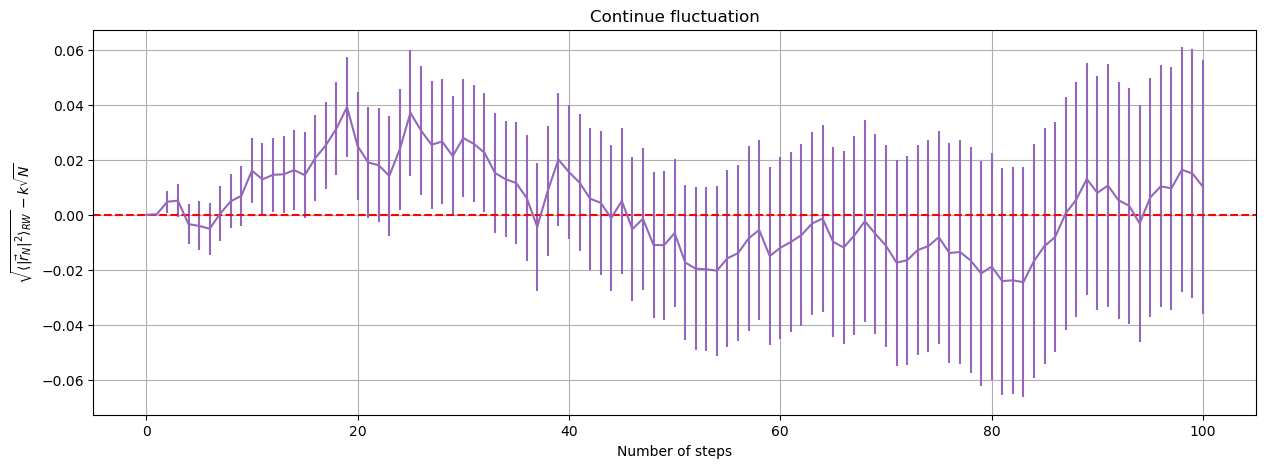

In [5]:
step, cum_avg, cumerror = np.loadtxt("../data/ex_02.2b.dat", unpack=True, usecols=(0,1, 2))

popt, pcov = curve_fit(k_law, step, cum_avg)

print("Fit parameter k: {ka:.3f}".format(ka=popt[0]))

x = np.linspace(0, 100, 1000)
y = k_law(x, popt[0])

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(step, cum_avg, yerr=cumerror, color=colors[4])
# plt.plot(x, y, label="Fit", color='red')
plt.title("Continue random walk")
plt.xlabel("Number of steps")
plt.ylabel(r'$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(step, cumerror, color=colors[4])
plt.title("Continue random walk")
plt.xlabel("Number of steps")
plt.ylabel(r"$\sigma$")
plt.grid(True)

plt.show()

plt.figure(figsize=(15,5))
plt.errorbar(step, cum_avg-k_law(step, popt[0]), yerr=cumerror, color=colors[4])
plt.axhline(0, color='red', linestyle='--')
plt.title("Continue fluctuation")
plt.xlabel("Number of steps")
plt.ylabel(r"$\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}} - k \sqrt{N}$")
plt.grid(True)

plt.show()

### Some observations
Both types of random walks fit into a diffusive behaviour, described by the law $k \sqrt(N)$, with $k \simeq 1.00$. 